# Motor Vehicle Collisions in NYC
## Prediciting the number of injuries from an NYC car wreck using several models

### Author: Jack Robbins

**Dataset Used**: https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95/about_data

In [4]:
# Important imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from IPython.display import display, HTML
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, ConfusionMatrixDisplay
from matplotlib.gridspec import GridSpec 
from sklearn.svm import SVC
from scipy.stats import randint

## Dataset Used

Our dataset is a collection of all motor vehicle crashses in the city of New York all the way back from April of 1998 up to present day when I am writing this(11/16/2024). This dataset is incredibly rich with over 2 million rows of data and 29 attributes(both numerical and categorical) for us to choose from.

In [5]:
# Read in our dataframe
collisions = pd.read_csv("data/Motor_Vehicle_Collisions_-_Crashes_20241116.csv", low_memory=False)

In [6]:
# Let's get an idea of our data
collisions.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
3,09/11/2021,9:35,BROOKLYN,11208,40.667202,-73.866500,"(40.667202, -73.8665)",NaN,NaN,1211 LORING AVENUE,...,NaN,NaN,NaN,NaN,4456314,Sedan,NaN,NaN,NaN,NaN
4,12/14/2021,8:13,BROOKLYN,11233,40.683304,-73.917274,"(40.683304, -73.917274)",SARATOGA AVENUE,DECATUR STREET,NaN,...,NaN,NaN,NaN,NaN,4486609,NaN,NaN,NaN,NaN,NaN


In [7]:
# We can see that we have quit a few rows
collisions.shape

(2127188, 29)

## Data Preprocessing 

There is plenty of data in here that is junk, null or overall not useful for our purposes in here. We will now go through the process of cleaning the data to remove all of the unneeded values and convert any mismatched types.

In [8]:
null_values=collisions.isnull().sum()
print("Detecting missing values:\n", null_values)

Detecting missing values:
 CRASH DATE                             0
CRASH TIME                             0
BOROUGH                           661545
ZIP CODE                          661805
LATITUDE                          238998
LONGITUDE                         238998
LOCATION                          238998
ON STREET NAME                    455507
CROSS STREET NAME                 810739
OFF STREET NAME                  1764054
NUMBER OF PERSONS INJURED             18
NUMBER OF PERSONS KILLED              31
NUMBER OF PEDESTRIANS INJURED          0
NUMBER OF PEDESTRIANS KILLED           0
NUMBER OF CYCLIST INJURED              0
NUMBER OF CYCLIST KILLED               0
NUMBER OF MOTORIST INJURED             0
NUMBER OF MOTORIST KILLED              0
CONTRIBUTING FACTOR VEHICLE 1       7150
CONTRIBUTING FACTOR VEHICLE 2     333415
CONTRIBUTING FACTOR VEHICLE 3    1974243
CONTRIBUTING FACTOR VEHICLE 4    2092457
CONTRIBUTING FACTOR VEHICLE 5    2117737
COLLISION_ID                  

## Let's analyze these findings...
So we can see that there are a lot of missing values specifically for vehicles above code type 2. This is probably because there aren't that many 3, 4 or 5 car collisions in NYC. So instead of dropping rows where these are null, we may as well simply drop these columns. This also applies to the "CONTRIBUTING FACTOR VEHICLE.." columns for 3, 4 and 5. In fact, I am going to drop the rows where these aren't null, because I only care about one/two car collisions.

In [9]:
collisions.drop(['VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5', \
                 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', \
                 'CONTRIBUTING FACTOR VEHICLE 5'], axis=1, inplace=True)

In [10]:
collisions.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,0,0,0,2,0,Aggressive Driving/Road Rage,Unspecified,4455765,Sedan,Sedan
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,0,0,0,1,0,Pavement Slippery,NaN,4513547,Sedan,NaN
2,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,0,0,0,0,0,Following Too Closely,Unspecified,4541903,Sedan,Pick-up Truck
3,09/11/2021,9:35,BROOKLYN,11208,40.667202,-73.866500,"(40.667202, -73.8665)",NaN,NaN,1211 LORING AVENUE,...,0,0,0,0,0,Unspecified,NaN,4456314,Sedan,NaN
4,12/14/2021,8:13,BROOKLYN,11233,40.683304,-73.917274,"(40.683304, -73.917274)",SARATOGA AVENUE,DECATUR STREET,NaN,...,0,0,0,0,0,NaN,NaN,4486609,NaN,NaN


## Dropping NA's
Let's remove anything where the position or location of the crash was improperly recorded.

In [11]:
collisions.dropna(subset=['BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'LOCATION'], how='any', inplace=True)

As we can see now, we should have borough and position data for every single crash

In [12]:
collisions

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2
3,09/11/2021,9:35,BROOKLYN,11208,40.667202,-73.866500,"(40.667202, -73.8665)",NaN,NaN,1211 LORING AVENUE,...,0,0,0,0,0,Unspecified,NaN,4456314,Sedan,NaN
4,12/14/2021,8:13,BROOKLYN,11233,40.683304,-73.917274,"(40.683304, -73.917274)",SARATOGA AVENUE,DECATUR STREET,NaN,...,0,0,0,0,0,NaN,NaN,4486609,NaN,NaN
7,12/14/2021,8:17,BRONX,10475,40.868160,-73.831480,"(40.86816, -73.83148)",NaN,NaN,344 BAYCHESTER AVENUE,...,0,0,0,2,0,Unspecified,Unspecified,4486660,Sedan,Sedan
8,12/14/2021,21:10,BROOKLYN,11207,40.671720,-73.897100,"(40.67172, -73.8971)",NaN,NaN,2047 PITKIN AVENUE,...,0,0,0,0,0,Driver Inexperience,Unspecified,4487074,Sedan,NaN
9,12/14/2021,14:58,MANHATTAN,10017,40.751440,-73.973970,"(40.75144, -73.97397)",3 AVENUE,EAST 43 STREET,NaN,...,0,0,0,0,0,Passing Too Closely,Unspecified,4486519,Sedan,Station Wagon/Sport Utility Vehicle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127136,07/10/2024,18:34,BRONX,10454,40.812263,-73.920590,"(40.812263, -73.92059)",WILLIS AVENUE,EAST 143 STREET,NaN,...,0,0,0,0,0,Unspecified,NaN,4746499,Taxi,NaN
2127145,07/19/2024,18:00,BROOKLYN,11207,40.675735,-73.896860,"(40.675735, -73.89686)",ATLANTIC AVENUE,PENNSYLVANIA AVENUE,NaN,...,0,0,0,0,0,Turning Improperly,Unspecified,4746359,Sedan,Sedan
2127162,07/07/2024,14:12,BRONX,10468,40.861084,-73.911490,"(40.861084, -73.91149)",NaN,NaN,2258 HAMPDEN PLACE,...,0,0,0,0,0,Unspecified,NaN,4746320,Sedan,NaN
2127172,07/21/2024,18:05,BROOKLYN,11224,40.572968,-74.000595,"(40.572968, -74.000595)",NaN,NaN,3514 SURF AVENUE,...,0,0,0,0,0,Backing Unsafely,Unspecified,4746425,Station Wagon/Sport Utility Vehicle,Pick-up Truck


In [13]:
# Let's see how we're doing now...
null_values=collisions.isnull().sum()
print("Our null values now:\n", null_values)

Our null values now:
 CRASH DATE                             0
CRASH TIME                             0
BOROUGH                                0
ZIP CODE                               0
LATITUDE                               0
LONGITUDE                              0
LOCATION                               0
ON STREET NAME                    321239
CROSS STREET NAME                 321778
OFF STREET NAME                  1107450
NUMBER OF PERSONS INJURED             11
NUMBER OF PERSONS KILLED              23
NUMBER OF PEDESTRIANS INJURED          0
NUMBER OF PEDESTRIANS KILLED           0
NUMBER OF CYCLIST INJURED              0
NUMBER OF CYCLIST KILLED               0
NUMBER OF MOTORIST INJURED             0
NUMBER OF MOTORIST KILLED              0
CONTRIBUTING FACTOR VEHICLE 1       5376
CONTRIBUTING FACTOR VEHICLE 2     236603
COLLISION_ID                           0
VEHICLE TYPE CODE 1                10403
VEHICLE TYPE CODE 2               290014
dtype: int64


## Removing unneeded columns
So we're definitely in a better spot now, but there is still much more that we can do. Firstly, we can see those "STREET NAME" columns have a lot of null values in them. Since the name of the street is too atomic to be useful for our regression equation, we can just get rid of those columns entirely. We can also see that every crash has a unique crash ID given to it by the NYPD. Again, this won't help us all with regression, so we'll scrap it as well. Finally, the contributing factor column is not a standardized categorical column. The data in there are manually entered strings that would also not be of much use to us. Additionally, the crash date itself may be a pain to work with, and I don't foresee it coming up much for us. Location and zip code are other strange columns, as they are just proxies for latitude and longitude.

In [14]:
# Drop all of these columns in here
collisions.drop(['LOCATION','CROSS STREET NAME', 'ON STREET NAME', 'OFF STREET NAME', 'COLLISION_ID', \
                 'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'ZIP CODE', \
                 'ON STREET NAME', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
                 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED'
                 ], axis=1, inplace=True)

In [15]:
# Let's see how we're doing now...
null_values=collisions.isnull().sum()
print("Our null values now:\n", null_values)

Our null values now:
 CRASH DATE                         0
CRASH TIME                         0
BOROUGH                            0
LATITUDE                           0
LONGITUDE                          0
NUMBER OF PERSONS INJURED         11
NUMBER OF PERSONS KILLED          23
NUMBER OF MOTORIST INJURED         0
NUMBER OF MOTORIST KILLED          0
VEHICLE TYPE CODE 1            10403
VEHICLE TYPE CODE 2           290014
dtype: int64


## Dropping NA's in the remaining rows/columns
We're doing much better now. We still have around 250,000 columns with at least one NA. For our purposes here, since we have around 2 million rows, we can acceptably lose that data, so we'll now drop any rows with an NA

In [16]:
collisions.dropna(how='any', axis=0, inplace=True)

In [17]:
# Let's see how we're doing now...
null_values=collisions.isnull().sum()
print("Our null values now:\n", null_values)

Our null values now:
 CRASH DATE                    0
CRASH TIME                    0
BOROUGH                       0
LATITUDE                      0
LONGITUDE                     0
NUMBER OF PERSONS INJURED     0
NUMBER OF PERSONS KILLED      0
NUMBER OF MOTORIST INJURED    0
NUMBER OF MOTORIST KILLED     0
VEHICLE TYPE CODE 1           0
VEHICLE TYPE CODE 2           0
dtype: int64


In [18]:
# Let's see what how much we still have left over
collisions.shape

(1138114, 11)

## Dealing with time and type mismatches

Even though the data is cleaned from NA's, we still can't use it. Our dataset is still filled with categorical data that we'll need to encode numerically if we want to do any correlation analysis or regression on it.

In [19]:
collisions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1138114 entries, 7 to 2127172
Data columns (total 11 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   CRASH DATE                  1138114 non-null  object 
 1   CRASH TIME                  1138114 non-null  object 
 2   BOROUGH                     1138114 non-null  object 
 3   LATITUDE                    1138114 non-null  float64
 4   LONGITUDE                   1138114 non-null  float64
 5   NUMBER OF PERSONS INJURED   1138114 non-null  float64
 6   NUMBER OF PERSONS KILLED    1138114 non-null  float64
 7   NUMBER OF MOTORIST INJURED  1138114 non-null  int64  
 8   NUMBER OF MOTORIST KILLED   1138114 non-null  int64  
 9   VEHICLE TYPE CODE 1         1138114 non-null  object 
 10  VEHICLE TYPE CODE 2         1138114 non-null  object 
dtypes: float64(4), int64(2), object(5)
memory usage: 104.2+ MB


### Conversion Strategy

As we can see, there are several columns that are Objects(really strings) that we'll need to encode. A special case though is the crash date and crash time. We can convert crash time specifically into an integer representing the number of minutes since midnight by doing hours*60 + minutes. We'll use the help of a custom function for this.

We will also encode the crash date into a crash month. The idea here is that the exact day & year may be too granular, but we could find some broader trends if we use month as a predictor(maybe, for example, more people get injured in the winter)

In [20]:
def clock_time_to_minutes(clock_time):
    #Split the clock time along the colon
    split = clock_time.split(":")
    return int(split[1])*60 + int(split[0])

#Apply this to the CRASH TIME
collisions['CRASH TIME'] = collisions['CRASH TIME'].apply(clock_time_to_minutes)
    
def date_to_months(date):
    #Grab the month
    split = date.split("/")
    return int(split[0])

#Apply this to a DATE
collisions['CRASH MONTH'] = collisions['CRASH DATE'].apply(date_to_months)
collisions.drop(['CRASH DATE'], axis = 1,  inplace=True)

In [21]:
collisions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1138114 entries, 7 to 2127172
Data columns (total 11 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   CRASH TIME                  1138114 non-null  int64  
 1   BOROUGH                     1138114 non-null  object 
 2   LATITUDE                    1138114 non-null  float64
 3   LONGITUDE                   1138114 non-null  float64
 4   NUMBER OF PERSONS INJURED   1138114 non-null  float64
 5   NUMBER OF PERSONS KILLED    1138114 non-null  float64
 6   NUMBER OF MOTORIST INJURED  1138114 non-null  int64  
 7   NUMBER OF MOTORIST KILLED   1138114 non-null  int64  
 8   VEHICLE TYPE CODE 1         1138114 non-null  object 
 9   VEHICLE TYPE CODE 2         1138114 non-null  object 
 10  CRASH MONTH                 1138114 non-null  int64  
dtypes: float64(4), int64(4), object(3)
memory usage: 104.2+ MB


We can also see that Number of persons injured/killed is a float. Since we can't have fractional parts of people, we'll convert these into ints.

In [22]:
collisions['NUMBER OF PERSONS INJURED'] = collisions['NUMBER OF PERSONS INJURED'].apply(lambda x: int(x))
collisions['NUMBER OF PERSONS KILLED'] = collisions['NUMBER OF PERSONS KILLED'].apply(lambda x: int(x))
collisions = collisions[collisions['NUMBER OF PERSONS INJURED'] <= 5]

In [23]:
collisions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1136656 entries, 7 to 2127172
Data columns (total 11 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   CRASH TIME                  1136656 non-null  int64  
 1   BOROUGH                     1136656 non-null  object 
 2   LATITUDE                    1136656 non-null  float64
 3   LONGITUDE                   1136656 non-null  float64
 4   NUMBER OF PERSONS INJURED   1136656 non-null  int64  
 5   NUMBER OF PERSONS KILLED    1136656 non-null  int64  
 6   NUMBER OF MOTORIST INJURED  1136656 non-null  int64  
 7   NUMBER OF MOTORIST KILLED   1136656 non-null  int64  
 8   VEHICLE TYPE CODE 1         1136656 non-null  object 
 9   VEHICLE TYPE CODE 2         1136656 non-null  object 
 10  CRASH MONTH                 1136656 non-null  int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 104.1+ MB


### Encoding Categorical Data
We're almost there, but we still have 3 categorical data columns in the VEHICLE TYPE CODE columns and BOROUGH columns. We will use label encoding to assign these all corresponding numerical values.

In [24]:
borough_le = preprocessing.LabelEncoder()
# Note that we want to use the same label encoder for both type code sets
typecode_le = preprocessing.LabelEncoder()
# Use a label encoder for ON STREET NAME
street_name_le = preprocessing.LabelEncoder()

collisions.loc[:,'BOROUGH'] = borough_le.fit_transform(collisions['BOROUGH'])
typecode_le.fit(collisions['VEHICLE TYPE CODE 1'].values.tolist() + collisions['VEHICLE TYPE CODE 2'].values.tolist())
collisions.loc[:,'VEHICLE TYPE CODE 1'] = typecode_le.transform(collisions['VEHICLE TYPE CODE 1'])
collisions.loc[:,'VEHICLE TYPE CODE 2'] = typecode_le.transform(collisions['VEHICLE TYPE CODE 2'])

In [25]:
collisions

,CRASH TIME,BOROUGH,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,CRASH MONTH
7,1028,0,40.868160,-73.831480,2,0,2,0,1276,1276,12
9,3494,2,40.751440,-73.973970,0,0,0,0,1276,1305,12
11,3016,3,40.675884,-73.755770,0,0,0,0,1276,1305,12
14,623,3,40.666840,-73.789410,2,0,2,0,1276,1276,12
15,3497,1,40.681580,-73.974630,0,0,0,0,1373,1305,12
...,...,...,...,...,...,...,...,...,...,...,...
2127107,12,1,40.685658,-73.985695,1,0,0,0,1305,174,8
2127110,323,2,40.749130,-73.988240,1,0,0,0,174,1305,8
2127114,2709,3,40.684383,-73.790180,4,0,4,0,1276,1305,7
2127145,18,1,40.675735,-73.896860,0,0,0,0,1276,1276,7


Great, we've still got about 1.1 million rows of clean, null-free data remaining for us to play around with. We can now move on to searching for correlations in the dataset.

## Data Visualization - Hunting for correlations & patterns

We can look at a few visualizations to check and see if the data is inherently clustered in some way.

[Text(0.5, 1.0, 'VEHICLE TYPE CODE 1 FREQUENCY')]

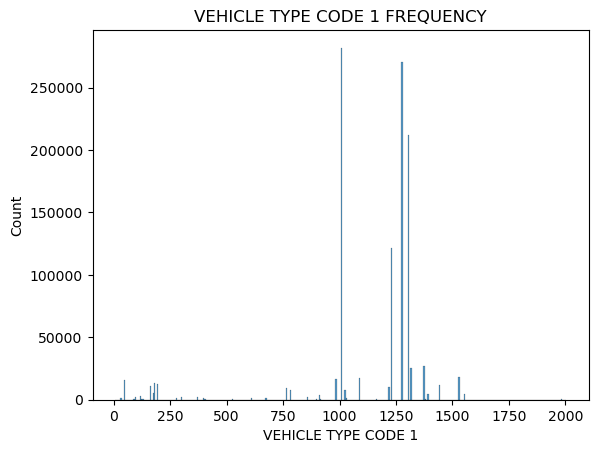

In [26]:
sns.histplot(data=collisions, x="VEHICLE TYPE CODE 1").set(title="VEHICLE TYPE CODE 1 FREQUENCY")

[Text(0.5, 1.0, 'VEHICLE 1 CODE vs. NUMBER OF PERSONS INJURED')]

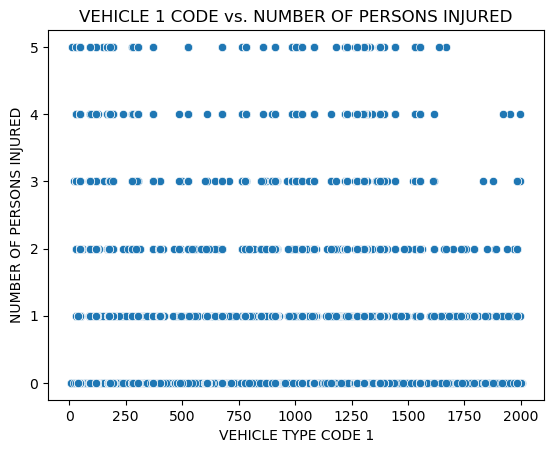

In [27]:
sns.scatterplot(data=collisions, x = "VEHICLE TYPE CODE 1", y = "NUMBER OF PERSONS INJURED").set(title="VEHICLE 1 CODE vs. NUMBER OF PERSONS INJURED")

[Text(0.5, 1.0, 'VEHICLE TYPE CODE 2 FREQUENCY')]

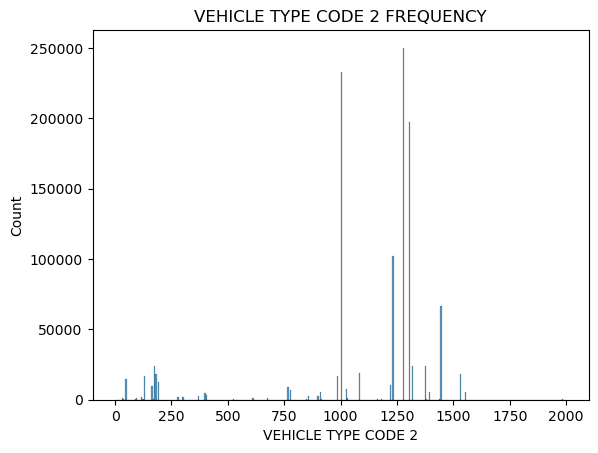

In [28]:
sns.histplot(data=collisions, x="VEHICLE TYPE CODE 2").set(title="VEHICLE TYPE CODE 2 FREQUENCY")

[Text(0.5, 1.0, 'VEHICLE 2 CODE vs. NUMBER OF PERSONS INJURED')]

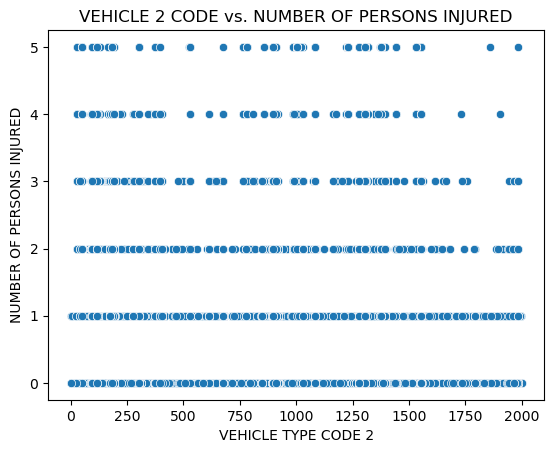

In [29]:
sns.scatterplot(data=collisions, x = "VEHICLE TYPE CODE 2", y = "NUMBER OF PERSONS INJURED").set(title="VEHICLE 2 CODE vs. NUMBER OF PERSONS INJURED")

[Text(0.5, 1.0, 'CRASH TIME FREQUENCY')]

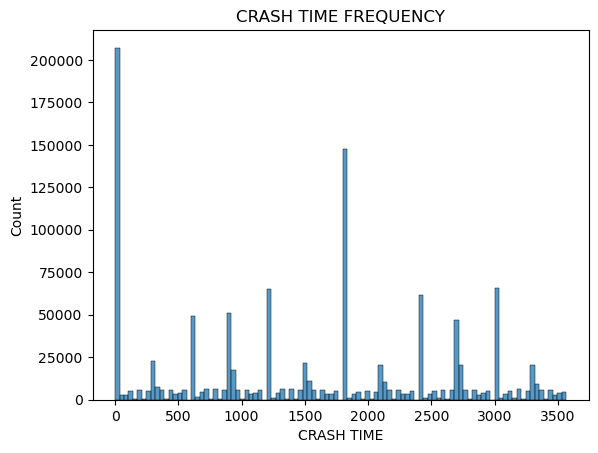

In [30]:
sns.histplot(data=collisions, x="CRASH TIME").set(title="CRASH TIME FREQUENCY")

[Text(0.5, 1.0, 'CRASH TIME vs. NUMBER OF PERSONS INJURED')]

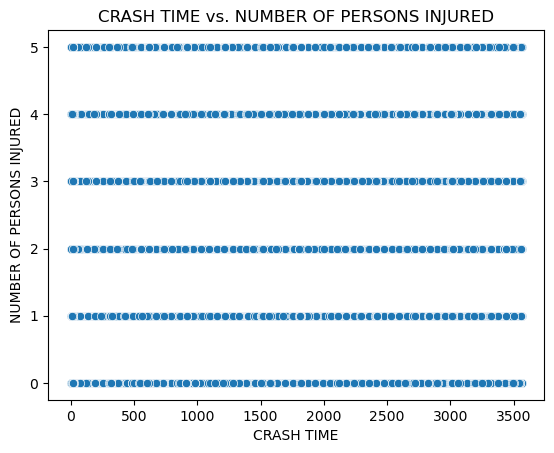

In [31]:
sns.scatterplot(data=collisions, x = "CRASH TIME", y = "NUMBER OF PERSONS INJURED").set(title="CRASH TIME vs. NUMBER OF PERSONS INJURED")

[Text(0.5, 1.0, 'CRASH MONTH FREQUENCY')]

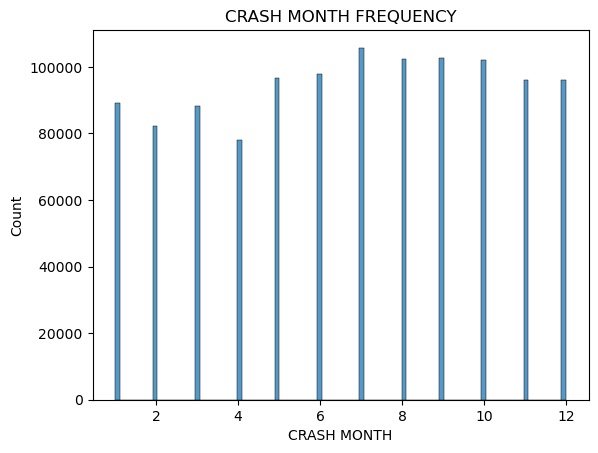

In [32]:
sns.histplot(data=collisions, x="CRASH MONTH").set(title="CRASH MONTH FREQUENCY")

[Text(0.5, 1.0, 'CRASH MONTH vs. NUMBER OF PERSONS INJURED')]

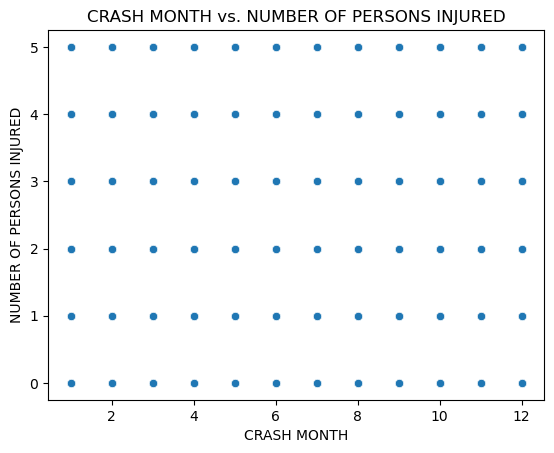

In [33]:
sns.scatterplot(data=collisions, x = "CRASH MONTH", y = "NUMBER OF PERSONS INJURED").set(title="CRASH MONTH vs. NUMBER OF PERSONS INJURED")

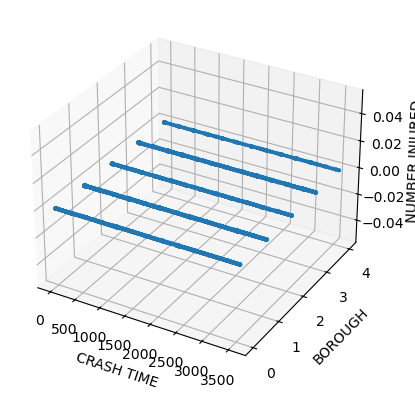

In [34]:
fig = plt.figure()
ax = plt.axes(projection='3d')

x = collisions['CRASH TIME']
y = collisions['BOROUGH']
z = collisions['NUMBER OF PERSONS INJURED']

ax.set_xlabel("CRASH TIME")
ax.set_ylabel("BOROUGH")
ax.set_zlabel("NUMBER INJURED")

plt.scatter(x, y, z)
plt.show()

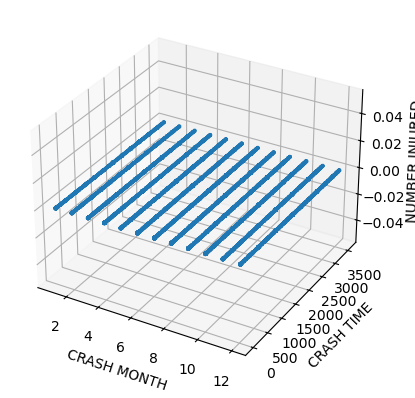

In [35]:
fig = plt.figure()
ax = plt.axes(projection='3d')

x = collisions['CRASH MONTH']
y = collisions['CRASH TIME']
z = collisions['NUMBER OF PERSONS INJURED']

ax.set_xlabel("CRASH MONTH")
ax.set_ylabel("CRASH TIME")
ax.set_zlabel("NUMBER INJURED")

plt.scatter(x, y, z)
plt.show()

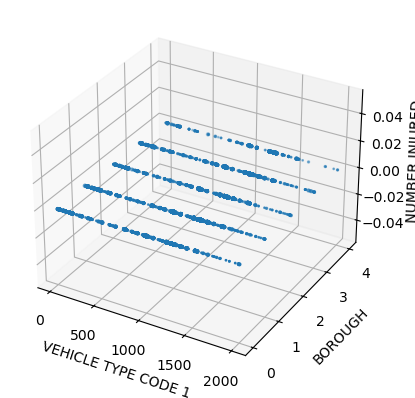

In [36]:
fig = plt.figure()
ax = plt.axes(projection='3d')

x = collisions['VEHICLE TYPE CODE 1']
y = collisions['BOROUGH']
z = collisions['NUMBER OF PERSONS INJURED']

ax.set_xlabel("VEHICLE TYPE CODE 1")
ax.set_ylabel("BOROUGH")
ax.set_zlabel("NUMBER INJURED")

plt.scatter(x, y, z)
plt.show()

[Text(0.5, 1.0, 'INJURY FREQUENCY')]

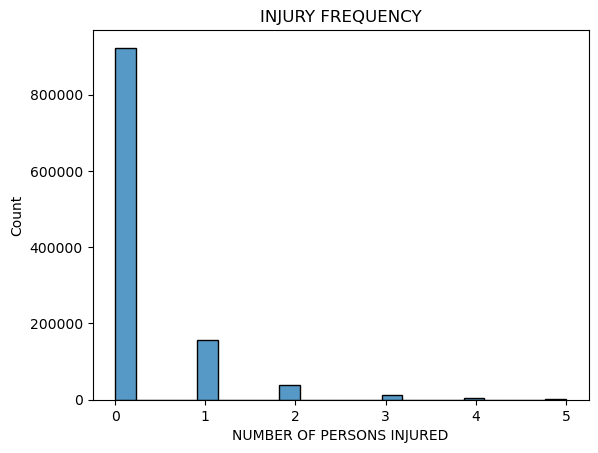

In [37]:
sns.histplot(data=collisions, x="NUMBER OF PERSONS INJURED").set(title="INJURY FREQUENCY")

## Training and scoring the Random Forest Classifier

Now that our data is preprocessed and encoded properly, we will train our classifier and evaluate its performance

**Predictors**: crash time, borough, vehicle type codes 1 & 2, crash month   
**Response**: number of persons injured(categorical data between 0 and 10)

[Text(0.5, 1.0, 'INJURY FREQUENCY')]

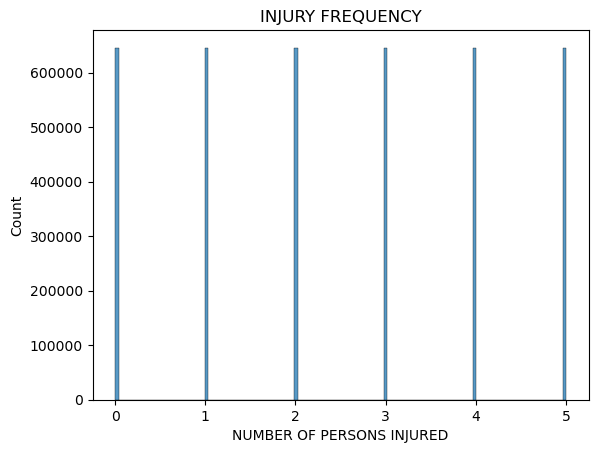

In [38]:
# Let's now split the data up
X = collisions[['CRASH TIME','BOROUGH', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'CRASH MONTH','LATITUDE', 'LONGITUDE']]
y = collisions[['NUMBER OF PERSONS INJURED']].to_numpy().flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

ros = imblearn.over_sampling.RandomOverSampler(sampling_strategy = 'not majority', random_state=410)
X_train_resample, y_train_resample = ros.fit_resample(X_train, y_train)

y_train_resample_df = pd.DataFrame(y_train_resample, columns=['NUMBER OF PERSONS INJURED'])
sns.histplot(data=y_train_resample_df, x="NUMBER OF PERSONS INJURED").set(title="INJURY FREQUENCY")

In [39]:
knn = KNeighborsClassifier()
param_dist = {"n_neighbors": range(4, 10),
              "weights": ["uniform", "distance"],
              "n_jobs": [-1]}

random_search = RandomizedSearchCV(knn, param_distributions=param_dist,
                                   n_iter=8, random_state = 410, cv=5, verbose=3)
random_search.fit(X_train, y_train)
random_search.best_score_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END n_jobs=-1, n_neighbors=5, weights=distance;, score=0.792 total time=   1.9s
[CV 2/5] END n_jobs=-1, n_neighbors=5, weights=distance;, score=0.792 total time=   1.9s
[CV 3/5] END n_jobs=-1, n_neighbors=5, weights=distance;, score=0.792 total time=   1.9s
[CV 4/5] END n_jobs=-1, n_neighbors=5, weights=distance;, score=0.793 total time=   1.9s
[CV 5/5] END n_jobs=-1, n_neighbors=5, weights=distance;, score=0.790 total time=   1.9s
[CV 1/5] END n_jobs=-1, n_neighbors=9, weights=distance;, score=0.803 total time=   2.1s
[CV 2/5] END n_jobs=-1, n_neighbors=9, weights=distance;, score=0.803 total time=   2.0s
[CV 3/5] END n_jobs=-1, n_neighbors=9, weights=distance;, score=0.804 total time=   2.0s
[CV 4/5] END n_jobs=-1, n_neighbors=9, weights=distance;, score=0.804 total time=   2.0s
[CV 5/5] END n_jobs=-1, n_neighbors=9, weights=distance;, score=0.802 total time=   2.0s
[CV 1/5] END n_jobs=-1, n_neighbors=8, weights=dis

0.8339351404464027

In [40]:
random_search.best_params_

{'weights': 'uniform', 'n_neighbors': 8, 'n_jobs': -1}

In [41]:
knn = KNeighborsClassifier(weights="uniform", n_neighbors=8, n_jobs=-1)
knn.fit(X_train, y_train)
cross_val_score(knn, X_test, y_test, cv=5)

array([0.833739  , 0.83277126, 0.83291544, 0.83389786, 0.83407381])

Accuracy of our KNN Model: 0.835
Precision of our KNN Model: 0.782
Recall of our KNN Model: 0.835
F1 score of our KNN Model: 0.792


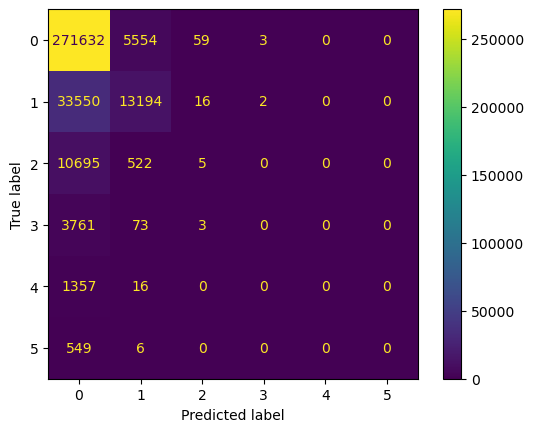

In [42]:
# Let's see how we did
y_pred = knn.predict(X_test)
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
# Precision 
precision = precision_score(y_test, y_pred,average='weighted', zero_division=0.0) 
# Recall 
recall = recall_score(y_test, y_pred,average='weighted', zero_division=0.0) 
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Accuracy of our KNN Model:{accuracy: .3f}')
print(f'Precision of our KNN Model:{precision: .3f}')
print(f'Recall of our KNN Model:{recall: .3f}')
print(f'F1 score of our KNN Model:{f1: .3f}')
cm = confusion_matrix(y_test, y_pred, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=knn.classes_)
disp.plot()

In [ ]:
# Let's train a decision tree model on this
param_dist = {"max_depth": range(3, 6),
              "max_features": range(3, 11),
              "min_samples_split": range(1, 10),
              "bootstrap": [True, False],
              "n_estimators": range(30, 60, 5),
              "criterion": ["gini", "entropy"],
              "n_jobs": [-1]}
rf = RandomForestClassifier()

random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=8, random_state = 410, cv=5, verbose=3)

random_search.fit(X_train, y_train)
random_search.best_score_


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END bootstrap=True, criterion=gini, max_depth=3, max_features=6, min_samples_split=3, n_estimators=30, n_jobs=-1;, score=0.831 total time=   3.1s
[CV 2/5] END bootstrap=True, criterion=gini, max_depth=3, max_features=6, min_samples_split=3, n_estimators=30, n_jobs=-1;, score=0.832 total time=   3.2s
[CV 3/5] END bootstrap=True, criterion=gini, max_depth=3, max_features=6, min_samples_split=3, n_estimators=30, n_jobs=-1;, score=0.831 total time=   3.0s
[CV 4/5] END bootstrap=True, criterion=gini, max_depth=3, max_features=6, min_samples_split=3, n_estimators=30, n_jobs=-1;, score=0.825 total time=   3.1s
[CV 5/5] END bootstrap=True, criterion=gini, max_depth=3, max_features=6, min_samples_split=3, n_estimators=30, n_jobs=-1;, score=0.831 total time=   3.1s
[CV 1/5] END bootstrap=True, criterion=entropy, max_depth=5, max_features=8, min_samples_split=6, n_estimators=50, n_jobs=-1;, score=0.832 total time=   8.7s
[CV 2/5

In [ ]:
random_search.best_params_

In [ ]:
rf = RandomForestClassifier(n_estimators=50, n_jobs=-1, min_samples_split=6, max_features=8, max_depth=5,criterion='entropy', \
                            bootstrap=True)
rf.fit(X_train, y_train)

In [ ]:
cross_val_score(rf, X_test, y_test, cv=5)

In [ ]:
# Let's see how we did
y_pred = rf.predict(X_test)
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
# Precision 
precision = precision_score(y_test, y_pred,average='weighted', zero_division=0.0) 
# Recall 
recall = recall_score(y_test, y_pred,average='weighted', zero_division=0.0) 
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Accuracy of our Decision Tree Model:{accuracy: .3f}')
print(f'Precision of our Decision Tree Model:{precision: .3f}')
print(f'Recall of our Decision Tree Model:{recall: .3f}')
print(f'F1 score of our Decision Tree Model:{f1: .3f}')
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf.classes_)
disp.plot()